In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
%matplotlib inline

In [2]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)

def acc_plot(history, name):
    plt.figure(figsize=(10,6))
    plt.plot(history['accuracy'], label='training accuracy')
    plt.plot(history['val_accuracy'], label='validation accuracy')
    plt.plot(history['loss'], label='training loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title(name + ' _Result')
    plt.xlabel('epochs')
    plt.legend()
    plt.savefig(name +'_Result.png', bbox_inches='tight', dpi=300)
    plt.show()
    
#     plt.figure(figsize=(10,6))
#     plt.plot(history['loss'], label='training loss')
#     plt.plot(history['val_loss'], label='validation loss')
#     plt.title(name + ' Loss')
#     plt.xlabel('epochs')
#     plt.legend()
# #     plt.savefig(name +'_Loss.png', bbox_inches='tight', dpi=300)
#     plt.show()
    
def gen_csv(model, name):
    result = dfTest[['Id']].copy()
    X_test = np.dstack([np.array(dfTest.iloc[:, 1:])] * 3).reshape(-1, 28, 28, 3)
    X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((64,64))) for im in X_test]).astype('float32')/255
    result['Label'] = np.argmax(model.predict(X_test), axis=1)
    result.to_csv('result' + name + '.csv', encoding='utf-8', index=False)

def identity_block(X, f, filters, stage, block):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape=(64, 64, 3), classes=5):
    """
    ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPool2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
       
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [3]:
df = pd.read_csv('train.csv').drop(columns=['Id'])
dfTest = pd.read_csv('testX.csv')
X = np.array(df.iloc[:, 1:])
y = to_categorical(np.array(df.iloc[:, 0]))

X = np.dstack([X] * 3).reshape(-1, 28, 28, 3)
X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((64,64))) for im in X]).astype('float32')/255
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 41s 861us/sample - loss: 0.9352 - accuracy: 0.6979 - val_loss: 0.5940 - val_accuracy: 0.7551
Epoch 2/15
48000/48000 [==============================] - 36s 743us/sample - loss: 0.4642 - accuracy: 0.8187 - val_loss: 0.4507 - val_accuracy: 0.8306
Epoch 3/15
48000/48000 [==============================] - 36s 741us/sample - loss: 0.3723 - accuracy: 0.8517 - val_loss: 0.3617 - val_accuracy: 0.8537
Epoch 4/15
48000/48000 [==============================] - 35s 733us/sample - loss: 0.3232 - accuracy: 0.8722 - val_loss: 0.3943 - val_accuracy: 0.8422
Epoch 5/15
48000/48000 [==============================] - 35s 739us/sample - loss: 0.2888 - accuracy: 0.8843 - val_loss: 0.3456 - val_accuracy: 0.8602
Epoch 6/15
48000/48000 [==============================] - 35s 734us/sample - loss: 0.2537 - accuracy: 0.9006 - val_loss: 0.3488 - val_accuracy: 0.8633
Epoch 7/15
48000/48000 [====================

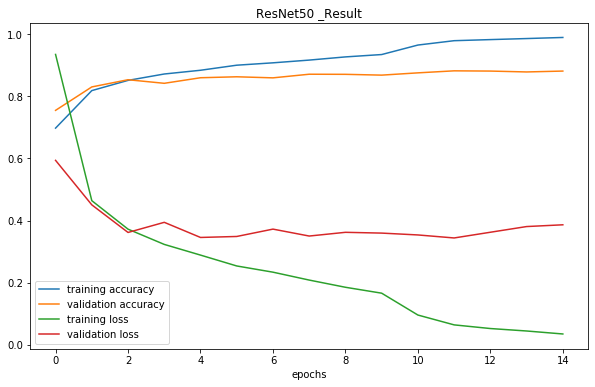

In [5]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
resnet50 = ResNet50(input_shape = (64, 64, 3), classes = 5)
resnet50.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
historyResnet = resnet50.fit(X_train, y_train, epochs = 15, batch_size = 128, verbose = 1, validation_data=(X_val, y_val), callbacks = [reduce_lr])
acc_plot(historyResnet.history, 'ResNet50')
# gen_csv(resnet50, 'ResNet50')

In [3]:
resnet50 = ResNet50(input_shape = (64, 64, 3), classes = 5)
plot_model(model = resnet50, to_file='ResNet50.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=300)

In [4]:
resnet50 = ResNet50(input_shape = (64, 64, 3), classes = 5)
resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
time_callback = TimeHistory()
resnet50.fit(X_train, y_train, epochs = 5, batch_size = 128, verbose = 0, validation_data=(X_val, y_val), callbacks = [time_callback])
print(time_callback.times)
start = time()
resnet50.evaluate(X_val, y_val, verbose=0)
print(time()-start)

[44.56914925575256, 36.00621676445007, 36.28971195220947, 35.974493980407715, 35.80961847305298]
7.658624887466431
